Youre my assistant for my research project. Youre very much knowledgeble on machine learning,neural networks and distributed computing. i want you to write code thats related to my prompt while also teaching me things and suggest things. my project is distributed gradient descent for sparse data.
the motive of the project is to reduce the communication overhead(figure out best aggregation way so that in a distributed training environment we fetch results similar to our base model). we will be dealing with sparse data (movielens 32m) in this experimental project.
as of now ive built 3 approaches 
1.base (1 node full data training)
2.data split (N nodes training on split data)
3.epoch split (N nodes training on split data but for few epochs)
every node here is a replica ie the architecture of my neural network is same and they perform neural collaberative filtering approach.
this is the progress ive made up until now and ill tell you my ideas and want you to implement those idea wrt my code and also give suggestion on my project.

In [1]:
try:
    spark.stop()
except:
    pass

In [1]:
import torch
print(torch.__version__)

2.5.1


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MovieRecSys").getOrCreate()
print(spark.version)

4.0.0


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType

schema = StructType([
    StructField("userId", IntegerType(), True),
    StructField("movieId", IntegerType(), True),
    StructField("rating", FloatType(), True)
])
# Read ratings.csv
df = spark.read.csv("ratings.csv", header=True, schema = schema).cache()
print(df.count())
# Select first 1000 unique users
unique_users = df.select("userId").distinct().limit(1000)

# Keep only rows from these users
df = df.join(unique_users, on="userId", how="inner")

df.show(5)
print("Rows after limiting:", df.count())
print("Unique users:", df.select("userId").distinct().count())
print("Unique Movies:", df.select("movieId").distinct().count())

32000204
+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|    28|      1|   4.0|
|    28|      2|   3.0|
|    28|      3|   4.0|
|    28|      5|   2.0|
|    28|      6|   3.0|
+------+-------+------+
only showing top 5 rows
Rows after limiting: 154972
Unique users: 1000
Unique Movies: 11459


In [4]:
from pyspark.sql.functions import col, round as spark_round
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array

user_indexer = StringIndexer(inputCol="userId", outputCol="user")
movie_indexer = StringIndexer(inputCol="movieId", outputCol="movie")
assembler = VectorAssembler(inputCols=["rating"], outputCol="rating_vec")
scaler = MinMaxScaler(inputCol="rating_vec", outputCol="rating_scaled")

pipeline = Pipeline(stages=[user_indexer, movie_indexer, assembler, scaler])

pipeline_model = pipeline.fit(df)
scaled_df = pipeline_model.transform(df)

# Flatten vector -> float, then round to 1 decimal
scaled_df = scaled_df.withColumn(
    "rating_scaled",
    spark_round(vector_to_array(col("rating_scaled"))[0], 1)
)

# Keep only necessary columns
df_final = scaled_df.select("user", "movie", "rating_scaled")
df_final = df_final.cache()
df_final.show(5)

+----+-----+-------------+
|user|movie|rating_scaled|
+----+-----+-------------+
| 0.0| 11.0|          0.8|
| 0.0|157.0|          0.6|
| 0.0|456.0|          0.8|
| 0.0|389.0|          0.3|
| 0.0|139.0|          0.6|
+----+-----+-------------+
only showing top 5 rows


In [5]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [6]:
import torch

# 80% train, 20% test
train_df, test_df = df_final.randomSplit([0.8, 0.2], seed=42)

#Converting PySpark DF to Pandas to Tensors
train_pd = train_df.toPandas()
test_pd = test_df.toPandas()

X_train = torch.tensor(train_pd[["user", "movie"]].values)
y_train = torch.tensor(train_pd["rating_scaled"].values)

X_test = torch.tensor(test_pd[["user", "movie"]].values)
y_test = torch.tensor(test_pd["rating_scaled"].values)

print("Train count:", X_train.shape[0])
print("Train Label:",y_train.shape[0])
print("Test count:", X_test.shape[0])
print("Test Label:",y_test.shape[0])

Train count: 123827
Train Label: 123827
Test count: 31145
Test Label: 31145


In [7]:
from torch.utils.data import TensorDataset, DataLoader

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
#print(train_dataset[2200])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class CollabFiltering(nn.Module):
    def __init__(self, n_users, n_movies, emb_dim, hidden, dropout):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_dim)   
        self.movie_emb = nn.Embedding(n_movies, emb_dim)  
        self.dropout_emb = 0.4

        self.mlp = nn.Sequential(
            nn.Linear(emb_dim * 2, hidden), 
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1),  
            nn.ReLU()  
        )

    def forward(self,user,movie):
        u = F.dropout(self.user_emb(user), p=self.dropout_emb, training=self.training)
        m = F.dropout(self.movie_emb(movie), p=self.dropout_emb, training=self.training)
        
        # Concatenate embeddings (instead of dot product)
        x = torch.cat([u, m], dim=1)
        
        # Pass through MLP
        return self.mlp(x).squeeze()

n_users = df_final.select("user").distinct().count()
n_movies = df_final.select("movie").distinct().count()



In [9]:
loss_fn = nn.MSELoss() # regression on ratings
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-5)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, weight_decay=1e-5)


In [10]:
def adam(parameter, m_state, v_state, t, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    # Loop over Tensors in model.parameters()
    for p in parameter:
        if p.grad is None:
            continue

        # First Time seeing this parameter
        if p not in m_state:
            m_state[p] = torch.zeros_like(p)
            v_state[p] = torch.zeros_like(p)

        g = p.grad
        # First moment
        m_state[p] = beta1 * m_state[p] + (1 - beta1) * g
        # Second moment
        v_state[p] = beta2 * v_state[p] + (1 - beta2) * (g * g)

        # Bias correction
        m_corrected = m_state[p] / (1 - beta1 ** t)
        v_corrected = v_state[p] / (1 - beta2 ** t)

        # Parameter update (in-place)
        p.data -= lr * m_corrected / (torch.sqrt(v_corrected) + epsilon)

    return m_state, v_state



================ RUN 1/2 ================
Epoch 1/10 | Train Loss: 0.0527, Train RMSE: 0.2296 | Test Loss: 0.0452, Test RMSE: 0.2124
Epoch 2/10 | Train Loss: 0.0452, Train RMSE: 0.2126 | Test Loss: 0.0435, Test RMSE: 0.2086
Epoch 3/10 | Train Loss: 0.0427, Train RMSE: 0.2067 | Test Loss: 0.0411, Test RMSE: 0.2026
Epoch 4/10 | Train Loss: 0.0413, Train RMSE: 0.2033 | Test Loss: 0.0408, Test RMSE: 0.2021
Epoch 5/10 | Train Loss: 0.0405, Train RMSE: 0.2013 | Test Loss: 0.0403, Test RMSE: 0.2008
Epoch 6/10 | Train Loss: 0.0398, Train RMSE: 0.1994 | Test Loss: 0.0424, Test RMSE: 0.2060
Epoch 7/10 | Train Loss: 0.0394, Train RMSE: 0.1984 | Test Loss: 0.0397, Test RMSE: 0.1991
Epoch 8/10 | Train Loss: 0.0389, Train RMSE: 0.1973 | Test Loss: 0.0413, Test RMSE: 0.2032
Epoch 9/10 | Train Loss: 0.0390, Train RMSE: 0.1974 | Test Loss: 0.0401, Test RMSE: 0.2002
Epoch 10/10 | Train Loss: 0.0384, Train RMSE: 0.1960 | Test Loss: 0.0400, Test RMSE: 0.2001

================ RUN 2/2 ================
Epo

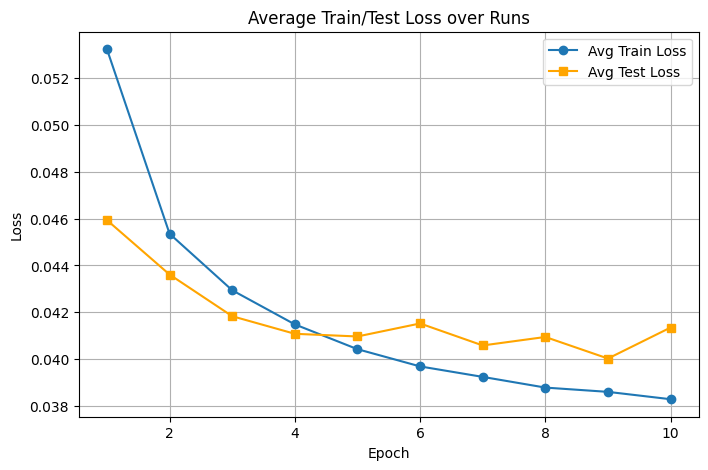

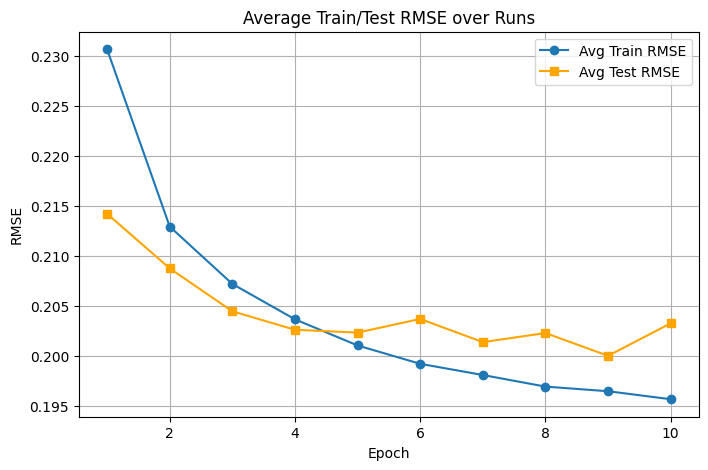

In [ ]:
import copy
import numpy as np
import matplotlib.pyplot as plt

n_runs = 2
n_epochs = 10

all_runs_train_losses = []
all_runs_test_losses = []
all_runs_train_rmses = []
all_runs_test_rmses = []



all_base = []  # store run stats (like your original)

for run in range(1, n_runs+1):
    print(f"\n================ RUN {run}/{n_runs} ================")

    # ----------Creating model-----------
    model = CollabFiltering(n_users, n_movies, emb_dim=16, hidden=16, dropout=0.1)
    m_state, v_state, t = {}, {}, 0

    best_rmse = float("inf")
    best_epoch = -1
    best_state = None

    train_losses_epoch, test_losses_epoch = [], []
    train_rmses_epoch, test_rmses_epoch = [], []
    epoch_states = []

    for epoch in range(n_epochs):
        # ---------- Training ----------
        model.train()
        total_loss, total_sq_error, total_samples = 0, 0, 0
        for X_batch, y_batch in train_loader:
            preds = model(X_batch[:,0].long(), X_batch[:,1].long()).squeeze()
            loss = loss_fn(preds, y_batch.float())
            model.zero_grad()
            loss.backward()
            t += 1
            m_state, v_state = adam(model.parameters(), m_state, v_state, t)

            total_loss += loss.item()
            total_sq_error += torch.sum((preds - y_batch)**2).item()
            total_samples += len(y_batch)

        train_loss = total_loss / len(train_loader)
        train_rmse = (total_sq_error / total_samples)**0.5

        # ---------- Testing ----------
        model.eval()
        total_loss, total_sq_error, total_samples = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                preds = model(X_batch[:,0].long(), X_batch[:,1].long()).squeeze()
                loss = loss_fn(preds, y_batch.float())
                total_loss += loss.item()
                total_sq_error += torch.sum((preds - y_batch)**2).item()
                total_samples += len(y_batch)

        test_loss = total_loss / len(test_loader)
        test_rmse = (total_sq_error / total_samples)**0.5

        # ---------- Save per-epoch stats ----------
        train_losses_epoch.append(train_loss)
        test_losses_epoch.append(test_loss)
        train_rmses_epoch.append(train_rmse)
        test_rmses_epoch.append(test_rmse)
        epoch_states.append(copy.deepcopy(model.state_dict()))

        print(f"Epoch {epoch+1}/{n_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f} | "
              f"Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")

        # ---------- Check best ----------
        if test_rmse < best_rmse:
            best_rmse = test_rmse
            best_epoch = epoch+1
            best_state = copy.deepcopy(model.state_dict())

    # Store run info
    all_base.append({
        "id": run,
        "train_losses": train_losses_epoch,
        "test_losses": test_losses_epoch,
        "train_rmses": train_rmses_epoch,
        "test_rmses": test_rmses_epoch,
        "epoch_states": epoch_states,
        "best_epoch": best_epoch,
        "best_rmse": best_rmse
    })

    # Save results for averaging
    all_runs_train_losses.append(train_losses_epoch)
    all_runs_test_losses.append(test_losses_epoch)
    all_runs_train_rmses.append(train_rmses_epoch)
    all_runs_test_rmses.append(test_rmses_epoch)

    # Load best model of this run
    model.load_state_dict(best_state)


# ---------- Average over runs ----------
avg_train_losses = np.mean(all_runs_train_losses, axis=0)
avg_test_losses = np.mean(all_runs_test_losses, axis=0)
avg_train_rmses = np.mean(all_runs_train_rmses, axis=0)
avg_test_rmses = np.mean(all_runs_test_rmses, axis=0)

# ---------- Plot Avg Train/Test Loss ----------
plt.figure(figsize=(8,5))
plt.plot(range(1, n_epochs+1), avg_train_losses, marker='o', label="Avg Train Loss")
plt.plot(range(1, n_epochs+1), avg_test_losses, marker='s', label="Avg Test Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Average Train/Test Loss over Runs")
plt.legend()
plt.grid(True)
plt.show()

# ---------- Plot Avg Train/Test RMSE ----------
plt.figure(figsize=(8,5))
plt.plot(range(1, n_epochs+1), avg_train_rmses, marker='o', label="Avg Train RMSE")
plt.plot(range(1, n_epochs+1), avg_test_rmses, marker='s', label="Avg Test RMSE", color="orange")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Average Train/Test RMSE over Runs")
plt.legend()
plt.grid(True)
plt.show()


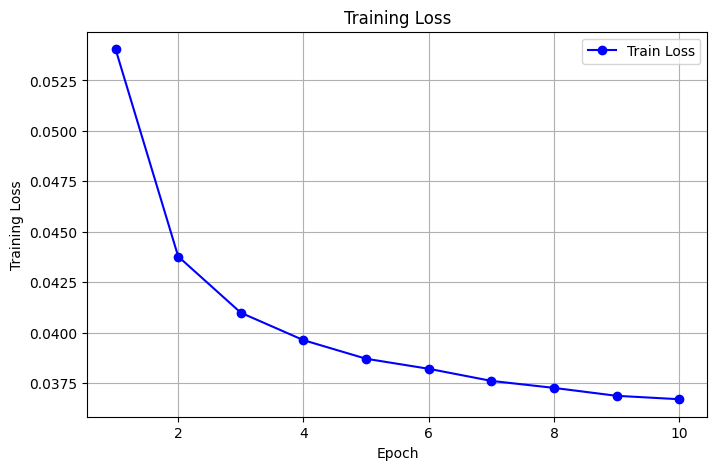

In [ ]:
# import matplotlib.pyplot as plt

# # Extract train losses
# train_losses = all_base[0]["train_losses"]
# n_epochs = len(train_losses)

# # Plot
# plt.figure(figsize=(8,5))
# plt.plot(range(1, n_epochs+1), train_losses, marker='o', color='blue', label="Train Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Training Loss")
# plt.title("Training Loss")
# plt.grid(True)
# plt.legend()
# plt.show()


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import copy

In [13]:
import utils

metrics = {
    "train_losses": all_base[0]["train_losses"],
    "test_rmses": all_base[0]["test_rmses"],
    "avg_train_losses": avg_train_losses,
    "avg_test_losses": avg_test_losses
}

# Save to a pickle file
utils.save_results("results/base_approach.pkl", metrics)


**PSO**

*******


In [ ]:
# --- Safe PSO Optimizer (Single Particle + Stable Updates) ---
import torch

class PSOOptimizer:
    def __init__(self, model, w, c1, c2, noise_scale, clip_val):
        self.params = [p for p in model.parameters() if p.requires_grad]
        self.velocities = [torch.zeros_like(p) for p in self.params]
        self.pbest = [p.clone() for p in self.params]
        self.gbest = [p.clone() for p in self.params]
        self.pbest_losses = [float('inf')] * len(self.params)
        self.best_loss = float('inf')

        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.noise_scale = noise_scale
        self.clip_val = clip_val  #clamp velocity magnitude

    def step(self, model, loss_value):
        # ---- Update global best ----
        if loss_value < self.best_loss:
            self.best_loss = loss_value
            self.gbest = [p.clone().detach() for p in model.parameters() if p.requires_grad]

        # ---- Update personal bests ----
        for i, p in enumerate(model.parameters()):
            if p.requires_grad and loss_value < self.pbest_losses[i]:
                self.pbest[i] = p.clone().detach()
                self.pbest_losses[i] = loss_value

        # ---- PSO velocity update with safe exploration ----
        for i, p in enumerate(self.params):
            v = self.velocities[i]
            pbest = self.pbest[i]
            gbest = self.gbest[i]

            r1 = torch.rand_like(p)
            r2 = torch.rand_like(p)

            # Safe PSO updates (detached)
            inertia = self.w * v
            cognitive = self.c1 * r1 * (pbest - p).detach()
            social = self.c2 * r2 * (gbest - p).detach()
            exploration = torch.randn_like(p) * self.noise_scale

            new_v = inertia + cognitive + social + exploration

            # Clip to prevent exploding velocity
            new_v = torch.clamp(new_v, -self.clip_val, self.clip_val)

            self.velocities[i] = new_v.detach()
            p.data += new_v.detach()


In [12]:
# --- Section 5: Training with Plain PSO (Clean + Debug Ready) ---
import numpy as np
import copy

n_runs = 1
n_epochs = 10

# Dictionary to store PSO metrics (similar to psog)
pso = {
    "train_losses": [],
    "test_losses": [],
    "train_rmses": [],
    "test_rmses": []
}

for run in range(1, n_runs + 1):
    print(f"\n================ RUN {run}/{n_runs} ================")

    model = CollabFiltering(n_users, n_movies, emb_dim=16, hidden=16, dropout=0.1)
    pso_optimizer = PSOOptimizer(model, w=0.6, c1=1.2, c2=1.5, noise_scale=0.01, clip_val=0.05)

    best_rmse, best_epoch, best_state = float("inf"), -1, None
    train_losses_epoch, test_losses_epoch = [], []
    train_rmses_epoch, test_rmses_epoch = [], []

    for epoch in range(n_epochs):
        # ---- TRAIN ----
        model.train()
        total_loss, total_sq_error, total_samples = 0, 0, 0

        for X_batch, y_batch in train_loader:
            preds = model(X_batch[:, 0].long(), X_batch[:, 1].long()).squeeze()
            loss = loss_fn(preds, y_batch.float())
            loss_value = loss.item()

            # PSO step (no gradients)
            pso_optimizer.step(model, loss_value)

            total_loss += loss_value
            total_sq_error += torch.sum((preds - y_batch) ** 2).item()
            total_samples += len(y_batch)

        train_loss = total_loss / len(train_loader)
        train_rmse = (total_sq_error / total_samples) ** 0.5

        # ---- TEST ----
        model.eval()
        total_loss, total_sq_error, total_samples = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                preds = model(X_batch[:, 0].long(), X_batch[:, 1].long()).squeeze()
                loss = loss_fn(preds, y_batch.float())
                total_loss += loss.item()
                total_sq_error += torch.sum((preds - y_batch) ** 2).item()
                total_samples += len(y_batch)

        test_loss = total_loss / len(test_loader)
        test_rmse = (total_sq_error / total_samples) ** 0.5

        # ---- Logging ----
        train_losses_epoch.append(train_loss)
        test_losses_epoch.append(test_loss)
        train_rmses_epoch.append(train_rmse)
        test_rmses_epoch.append(test_rmse)

        print(f"Epoch {epoch+1}/{n_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f} | "
              f"Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")

        # ---- Debug Info ----
        with torch.no_grad():
            weights = torch.cat([p.flatten() for p in model.parameters()])
            weights_mean, weights_std = weights.mean().item(), weights.std().item()
            vels = torch.cat([v.flatten() for v in pso_optimizer.velocities])
            vel_mean, vel_std = vels.mean().item(), vels.std().item()

        print(f"  [DEBUG] Weights mean: {weights_mean:.6f}, std: {weights_std:.6f}")
        print(f"  [DEBUG] Velocity mean: {vel_mean:.6f}, std: {vel_std:.6f}")
        print(f"  [DEBUG] Best (global) loss so far: {pso_optimizer.best_loss:.6f}")

        sample_users = torch.randint(0, n_users, (5,))
        sample_items = torch.randint(0, n_movies, (5,))
        sample_preds = model(sample_users, sample_items).detach().cpu().numpy().flatten()
        print(f"  Sample predictions: {np.round(sample_preds, 3)}")
        print("-" * 60)

        # ---- Save Best ----
        if test_rmse < best_rmse:
            best_rmse = test_rmse
            best_epoch = epoch + 1
            best_state = copy.deepcopy(model.state_dict())

    # Store run metrics into pso dictionary
    pso["train_losses"].append(train_losses_epoch)
    pso["test_losses"].append(test_losses_epoch)
    pso["train_rmses"].append(train_rmses_epoch)
    pso["test_rmses"].append(test_rmses_epoch)

print("\nTraining complete for all PSO runs.")



================ RUN 1/1 ================
Epoch 1/10 | Train Loss: 0.3486, Train RMSE: 0.5905 | Test Loss: 0.3049, Test RMSE: 0.5521
  [DEBUG] Weights mean: -0.003384, std: 1.002823
  [DEBUG] Velocity mean: 0.000087, std: 0.019972
  [DEBUG] Best (global) loss so far: 0.214576
  Sample predictions: [0.    0.641 0.    0.371 0.669]
------------------------------------------------------------
Epoch 2/10 | Train Loss: 0.3288, Train RMSE: 0.5734 | Test Loss: 0.2975, Test RMSE: 0.5453
  [DEBUG] Weights mean: -0.003387, std: 1.002908
  [DEBUG] Velocity mean: 0.000040, std: 0.019955
  [DEBUG] Best (global) loss so far: 0.204844
  Sample predictions: [1.127 0.528 0.    0.441 0.088]
------------------------------------------------------------
Epoch 3/10 | Train Loss: 0.3258, Train RMSE: 0.5708 | Test Loss: 0.3096, Test RMSE: 0.5563
  [DEBUG] Weights mean: -0.003422, std: 1.003029
  [DEBUG] Velocity mean: 0.000011, std: 0.019980
  [DEBUG] Best (global) loss so far: 0.178763
  Sample predictions: 

In [13]:
# --- Swarm PSO Optimizer (Multi-Particle Version + Stable Updates) ---
import torch
import copy

class SwarmPSOOptimizer:
    def __init__(self, model, n_particles, w, c1, c2, noise_scale, clip_val):
        """
        Multi-particle PSO for PyTorch models.

        Args:
            model: Base PyTorch model (will be cloned for each particle)
            n_particles: Number of swarm particles
            w, c1, c2: Inertia, cognitive, and social coefficients
            noise_scale: Random noise strength for exploration
            clip_val: Velocity clipping threshold
        """
        self.n_particles = n_particles
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.noise_scale = noise_scale
        self.clip_val = clip_val

        # Each particle has its own model copy
        self.particles = [copy.deepcopy(model) for _ in range(n_particles)]
        self.velocities = [
            [torch.zeros_like(p) for p in m.parameters() if p.requires_grad]
            for m in self.particles
        ]

        # Personal bests
        self.pbest = [copy.deepcopy(m) for m in self.particles]
        self.pbest_losses = [float('inf')] * n_particles

        # Global best (shared)
        self.gbest = copy.deepcopy(model)
        self.best_loss = float('inf')

    def step(self, losses):
        """
        Perform one PSO update for all particles.
        Args:
            losses: List of loss values (one per particle)
        """
        # ---- Update personal and global bests ----
        for i in range(self.n_particles):
            if losses[i] < self.pbest_losses[i]:
                self.pbest_losses[i] = losses[i]
                self.pbest[i] = copy.deepcopy(self.particles[i])

            if losses[i] < self.best_loss:
                self.best_loss = losses[i]
                self.gbest = copy.deepcopy(self.particles[i])

        # ---- Update positions and velocities ----
        for i in range(self.n_particles):
            params = [p for p in self.particles[i].parameters() if p.requires_grad]
            vels = self.velocities[i]
            pbest_params = [p for p in self.pbest[i].parameters() if p.requires_grad]
            gbest_params = [p for p in self.gbest.parameters() if p.requires_grad]

            for j, p in enumerate(params):
                v = vels[j]
                pbest = pbest_params[j]
                gbest = gbest_params[j]

                r1 = torch.rand_like(p)
                r2 = torch.rand_like(p)

                # Velocity update
                inertia = self.w * v
                cognitive = self.c1 * r1 * (pbest - p).detach()
                social = self.c2 * r2 * (gbest - p).detach()
                exploration = torch.randn_like(p) * self.noise_scale

                new_v = inertia + cognitive + social + exploration
                new_v = torch.clamp(new_v, -self.clip_val, self.clip_val)

                vels[j] = new_v.detach()
                p.data += new_v.detach()

    def get_best_model(self):
        """Return the current global best model."""
        return copy.deepcopy(self.gbest)


In [16]:
# --- Section 5: Training with Swarm PSO (Multi-Particle) ---
n_runs = 1
n_epochs = 10
n_particles = 10  # number of particles in the swarm

# Dictionary to store Swarm PSO metrics
psoswarm = {
    "train_losses": [],
    "test_losses": [],
    "train_rmses": [],
    "test_rmses": []
}

for run in range(1, n_runs + 1):
    print(f"\n================ RUN {run}/{n_runs} ================")

    base_model = CollabFiltering(n_users, n_movies, emb_dim=16, hidden=16, dropout=0.1)
    swarm_optimizer = SwarmPSOOptimizer(base_model, n_particles=n_particles,
                                        w=0.6, c1=1.2, c2=1.5, noise_scale=0.01, clip_val=0.05)

    best_rmse, best_epoch, best_model_state = float("inf"), -1, None
    train_losses_epoch, test_losses_epoch = [], []
    train_rmses_epoch, test_rmses_epoch = [], []

    for epoch in range(n_epochs):
        # ---- TRAIN ----
        epoch_particle_losses = []

        for i in range(n_particles):
            particle_model = swarm_optimizer.particles[i]
            particle_model.train()
            total_loss, total_sq_error, total_samples = 0, 0, 0

            for X_batch, y_batch in train_loader:
                preds = particle_model(X_batch[:, 0].long(), X_batch[:, 1].long()).squeeze()
                loss = loss_fn(preds, y_batch.float())
                total_loss += loss.item()
                total_sq_error += torch.sum((preds - y_batch) ** 2).item()
                total_samples += len(y_batch)

            avg_loss = total_loss / len(train_loader)
            epoch_particle_losses.append(avg_loss)

            # Optional: compute RMSE for logging
            particle_rmse = (total_sq_error / total_samples) ** 0.5

        # Update the swarm (all particles)
        swarm_optimizer.step(epoch_particle_losses)

        # ---- Evaluate global best on train and test sets ----
        gbest_model = swarm_optimizer.get_best_model()

        # Train metrics
        gbest_model.train()
        total_loss, total_sq_error, total_samples = 0, 0, 0
        for X_batch, y_batch in train_loader:
            preds = gbest_model(X_batch[:, 0].long(), X_batch[:, 1].long()).squeeze()
            loss = loss_fn(preds, y_batch.float())
            total_loss += loss.item()
            total_sq_error += torch.sum((preds - y_batch) ** 2).item()
            total_samples += len(y_batch)

        train_loss = total_loss / len(train_loader)
        train_rmse = (total_sq_error / total_samples) ** 0.5

        # Test metrics
        gbest_model.eval()
        total_loss, total_sq_error, total_samples = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                preds = gbest_model(X_batch[:, 0].long(), X_batch[:, 1].long()).squeeze()
                loss = loss_fn(preds, y_batch.float())
                total_loss += loss.item()
                total_sq_error += torch.sum((preds - y_batch) ** 2).item()
                total_samples += len(y_batch)

        test_loss = total_loss / len(test_loader)
        test_rmse = (total_sq_error / total_samples) ** 0.5

        # ---- Logging ----
        train_losses_epoch.append(train_loss)
        test_losses_epoch.append(test_loss)
        train_rmses_epoch.append(train_rmse)
        test_rmses_epoch.append(test_rmse)

        print(f"Epoch {epoch+1}/{n_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f} | "
              f"Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")

        # ---- Debug Info ----
        with torch.no_grad():
            weights = torch.cat([p.flatten() for p in gbest_model.parameters()])
            weights_mean, weights_std = weights.mean().item(), weights.std().item()
            # Concatenate all velocities from all particles
            vels = torch.cat([torch.cat([v.flatten() for v in particle]) for particle in swarm_optimizer.velocities])
            vel_mean, vel_std = vels.mean().item(), vels.std().item()

        print(f"  [DEBUG] Weights mean: {weights_mean:.6f}, std: {weights_std:.6f}")
        print(f"  [DEBUG] Velocity mean: {vel_mean:.6f}, std: {vel_std:.6f}")
        print(f"  [DEBUG] Global best loss: {swarm_optimizer.best_loss:.6f}")

        # Sample predictions
        sample_users = torch.randint(0, n_users, (5,))
        sample_items = torch.randint(0, n_movies, (5,))
        sample_preds = gbest_model(sample_users, sample_items).detach().cpu().numpy().flatten()
        print(f"  Sample predictions: {np.round(sample_preds, 3)}")
        print("-" * 60)

        # ---- Save Best Model State ----
        if test_rmse < best_rmse:
            best_rmse = test_rmse
            best_epoch = epoch + 1
            best_model_state = copy.deepcopy(gbest_model.state_dict())

    # Store metrics for this run
    psoswarm["train_losses"].append(train_losses_epoch)
    psoswarm["test_losses"].append(test_losses_epoch)
    psoswarm["train_rmses"].append(train_rmses_epoch)
    psoswarm["test_rmses"].append(test_rmses_epoch)

print("\nTraining complete for all Swarm PSO runs.")



================ RUN 1/1 ================
Epoch 1/10 | Train Loss: 0.3783, Train RMSE: 0.6150 | Test Loss: 0.3721, Test RMSE: 0.6100
  [DEBUG] Weights mean: 0.002270, std: 0.996946
  [DEBUG] Velocity mean: 0.000001, std: 0.009990
  [DEBUG] Global best loss: 0.377225
  Sample predictions: [0.018 0.    0.132 0.049 0.08 ]
------------------------------------------------------------
Epoch 2/10 | Train Loss: 0.3614, Train RMSE: 0.6012 | Test Loss: 0.3558, Test RMSE: 0.5964
  [DEBUG] Weights mean: 0.002295, std: 0.996950
  [DEBUG] Velocity mean: 0.000029, std: 0.014805
  [DEBUG] Global best loss: 0.361307
  Sample predictions: [0.312 0.293 0.262 0.098 0.23 ]
------------------------------------------------------------
Epoch 3/10 | Train Loss: 0.3284, Train RMSE: 0.5730 | Test Loss: 0.3187, Test RMSE: 0.5645
  [DEBUG] Weights mean: 0.002244, std: 0.997062
  [DEBUG] Velocity mean: -0.000037, std: 0.018126
  [DEBUG] Global best loss: 0.328064
  Sample predictions: [0.    0.    0.315 0.288 0.37

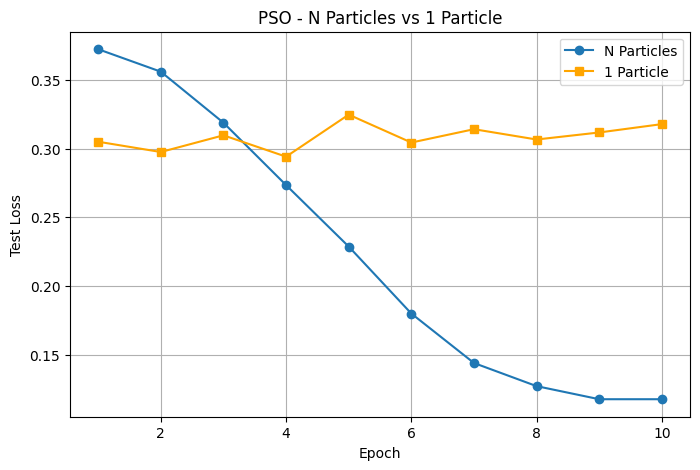

In [17]:
import matplotlib.pyplot as plt
import numpy as np

epochs = range(1, n_epochs+1)

# GD: mean across 3 runs
psoswarm_plot = psoswarm["test_losses"][0]
# PSO: single run
pso_plot = pso["test_losses"][0]

plt.figure(figsize=(8,5))
plt.plot(epochs, psoswarm_plot, marker='o', label="N Particles")
plt.plot(epochs, pso_plot, marker='s', label="1 Particle", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.title("PSO - N Particles vs 1 Particle")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# --- Hybrid PSO + Gradient Optimizer (Single Particle + Stable Updates) ---
class HybridPSO:
    def __init__(self, model, w, c1, c2, eta, scale_factor, noise_scale, clip_val):
        self.params = [p for p in model.parameters() if p.requires_grad]
        self.velocities = [torch.zeros_like(p) for p in self.params]
        self.pbest = [p.clone() for p in self.params]
        self.gbest = [p.clone() for p in self.params]
        self.pbest_losses = [float('inf')] * len(self.params)
        self.best_loss = float('inf')

        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.eta = eta            # gradient learning rate
        self.scale_factor = scale_factor  # scale factor for gradient term
        self.noise_scale = noise_scale
        self.clip_val = clip_val  # clamp velocity magnitude

    def step(self, model, loss_value):
        # ---- Update global best ----
        if loss_value < self.best_loss:
            self.best_loss = loss_value
            self.gbest = [p.clone().detach() for p in model.parameters() if p.requires_grad]

        # ---- Update personal bests ----
        for i, p in enumerate(model.parameters()):
            if p.requires_grad and loss_value < self.pbest_losses[i]:
                self.pbest[i] = p.clone().detach()
                self.pbest_losses[i] = loss_value

        # ---- PSO + gradient update ----
        for i, p in enumerate(self.params):
            v = self.velocities[i]
            pbest = self.pbest[i]
            gbest = self.gbest[i]

            r1 = torch.rand_like(p)
            r2 = torch.rand_like(p)

            # PSO terms
            inertia = self.w * v
            cognitive = self.c1 * r1 * (pbest - p).detach()
            social = self.c2 * r2 * (gbest - p).detach()
            exploration = torch.randn_like(p) * self.noise_scale

            # Gradient influence term (raw, unnormalized)
            grad_influence = torch.zeros_like(p)
            if p.grad is not None:
                grad = p.grad.data
                grad_norm = grad / (torch.norm(grad) + 1e-8)
        
                grad_influence = self.eta * self.scale_factor * grad_norm

            # Combine updates
            new_v = inertia + cognitive + social - grad_influence + exploration

            # Clip velocity
            new_v = torch.clamp(new_v, -self.clip_val, self.clip_val)

            # Update velocity and parameters
            self.velocities[i] = new_v.detach()
            p.data += new_v.detach()


In [20]:
# --- Section 5: Training with Hybrid PSO (PSO + Gradients) ---
n_runs = 1
n_epochs = 10

# This will store all info for plotting later
psog = {
    "train_losses": [],
    "test_losses": [],
    "train_rmses": [],
    "test_rmses": []
}

for run in range(1, n_runs + 1):
    print(f"\n================ RUN {run}/{n_runs} ================")

    model = CollabFiltering(n_users, n_movies, emb_dim=16, hidden=16, dropout=0.1)
    pso = HybridPSO(model, w=0.6, c1=1.2, c2=1.5, eta=0.001, noise_scale=0.01, scale_factor=0.1, clip_val=0.05)

    best_rmse, best_epoch, best_state = float("inf"), -1, None
    train_losses_epoch, test_losses_epoch = [], []
    train_rmses_epoch, test_rmses_epoch = [], []

    for epoch in range(n_epochs):
        # ---- TRAIN ----
        model.train()
        total_loss, total_sq_error, total_samples = 0, 0, 0

        for X_batch, y_batch in train_loader:
            preds = model(X_batch[:, 0].long(), X_batch[:, 1].long()).squeeze()
            loss = loss_fn(preds, y_batch.float())
            loss_value = loss.item()

            model.zero_grad()
            loss.backward()
            pso.step(model, loss_value)  # Hybrid PSO step

            total_loss += loss_value
            total_sq_error += torch.sum((preds - y_batch) ** 2).item()
            total_samples += len(y_batch)

        train_loss = total_loss / len(train_loader)
        train_rmse = (total_sq_error / total_samples) ** 0.5

        # ---- TEST ----
        model.eval()
        total_loss, total_sq_error, total_samples = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                preds = model(X_batch[:, 0].long(), X_batch[:, 1].long()).squeeze()
                loss = loss_fn(preds, y_batch.float())
                total_loss += loss.item()
                total_sq_error += torch.sum((preds - y_batch) ** 2).item()
                total_samples += len(y_batch)

        test_loss = total_loss / len(test_loader)
        test_rmse = (total_sq_error / total_samples) ** 0.5

        # ---- Logging ----
        train_losses_epoch.append(train_loss)
        test_losses_epoch.append(test_loss)
        train_rmses_epoch.append(train_rmse)
        test_rmses_epoch.append(test_rmse)

        print(f"Epoch {epoch+1}/{n_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f} | "
              f"Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")

        # ---- Debug Info ----
        with torch.no_grad():
            weights = torch.cat([p.flatten() for p in model.parameters()])
            weights_mean, weights_std = weights.mean().item(), weights.std().item()
            vels = torch.cat([v.flatten() for v in pso.velocities])
            vel_mean, vel_std = vels.mean().item(), vels.std().item()

        print(f"  [DEBUG] Weights mean: {weights_mean:.6f}, std: {weights_std:.6f}")
        print(f"  [DEBUG] Velocity mean: {vel_mean:.6f}, std: {vel_std:.6f}")
        print(f"  [DEBUG] Best (global) loss so far: {pso.best_loss:.6f}")

        # Sample predictions
        sample_users = torch.randint(0, n_users, (5,))
        sample_items = torch.randint(0, n_movies, (5,))
        sample_preds = model(sample_users, sample_items).detach().cpu().numpy().flatten()
        print(f"  Sample predictions: {np.round(sample_preds, 3)}")
        print("-" * 60)

        # ---- Save Best ----
        if test_rmse < best_rmse:
            best_rmse = test_rmse
            best_epoch = epoch + 1
            best_state = copy.deepcopy(model.state_dict())

    # ---- Store run metrics for plotting ----
    psog["train_losses"].append(train_losses_epoch)
    psog["test_losses"].append(test_losses_epoch)
    psog["train_rmses"].append(train_rmses_epoch)
    psog["test_rmses"].append(test_rmses_epoch)

print("\nTraining complete for all Hybrid PSO runs.")



================ RUN 1/1 ================
Epoch 1/10 | Train Loss: 0.3104, Train RMSE: 0.5572 | Test Loss: 0.3260, Test RMSE: 0.5709
  [DEBUG] Weights mean: 0.003932, std: 0.997629
  [DEBUG] Velocity mean: 0.000003, std: 0.019924
  [DEBUG] Best (global) loss so far: 0.186695
  Sample predictions: [0.015 0.227 0.541 0.288 0.443]
------------------------------------------------------------
Epoch 2/10 | Train Loss: 0.3073, Train RMSE: 0.5543 | Test Loss: 0.3227, Test RMSE: 0.5680
  [DEBUG] Weights mean: 0.003843, std: 0.997688
  [DEBUG] Velocity mean: -0.000033, std: 0.019937
  [DEBUG] Best (global) loss so far: 0.186695
  Sample predictions: [0.304 0.115 0.057 0.188 0.134]
------------------------------------------------------------
Epoch 3/10 | Train Loss: 0.3073, Train RMSE: 0.5543 | Test Loss: 0.3400, Test RMSE: 0.5831
  [DEBUG] Weights mean: 0.003895, std: 0.997686
  [DEBUG] Velocity mean: -0.000033, std: 0.019947
  [DEBUG] Best (global) loss so far: 0.186695
  Sample predictions: [

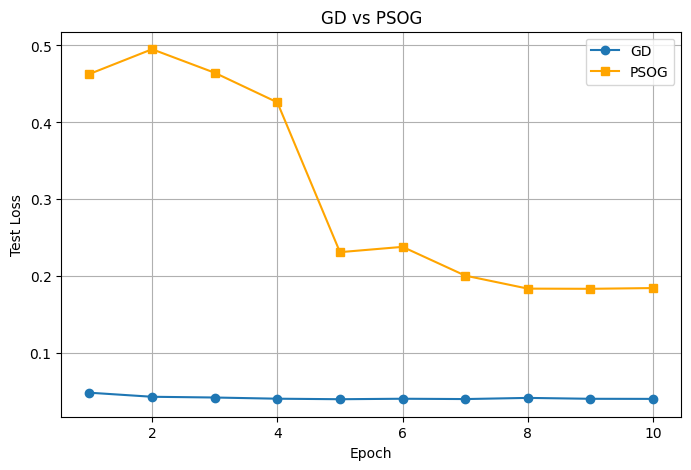

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epochs = range(1, n_epochs+1)

# GD: mean across 3 runs
gd_test_mean = np.mean(all_runs_test_losses, axis=0)

# PSO: single run
psog_test = psog["test_losses"][0]

plt.figure(figsize=(8,5))
plt.plot(epochs, gd_test_mean, marker='o', label="GD")
plt.plot(epochs, psog_test, marker='s', label="PSOG", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.title("GD vs PSOG")
plt.legend()
plt.grid(True)
plt.show()


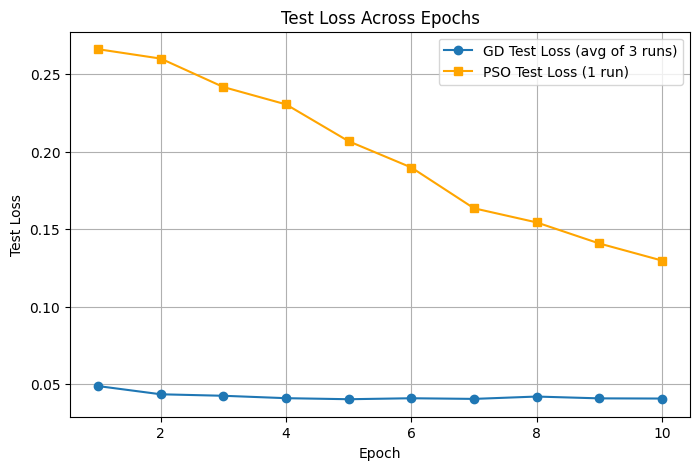

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epochs = range(1, n_epochs+1)

# GD: mean across 3 runs
gd_test_mean = np.mean(all_runs_test_losses, axis=0)

# PSO: single run
pso_test = pso["test_losses"][0]

plt.figure(figsize=(8,5))
plt.plot(epochs, gd_test_mean, marker='o', label="GD Test Loss (avg of 3 runs)")
plt.plot(epochs, pso_test, marker='s', label="PSO Test Loss (1 run)", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.title("Test Loss Across Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# --- Hybrid Swarm PSO + Gradient Optimizer (Multi-Particle) ---
import torch
import copy

class HybridSwarmPSO:
    def __init__(self, model, n_particles, w, c1, c2,
                 eta, scale_factor, noise_scale, clip_val):
        """
        Multi-particle Hybrid PSO optimizer with gradient influence.

        Args:
            model: base PyTorch model
            n_particles: number of particles in swarm
            w, c1, c2: PSO hyperparameters
            eta: gradient learning rate
            scale_factor: scales gradient influence
            noise_scale: random exploration
            clip_val: max velocity magnitude
        """
        self.n_particles = n_particles
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.eta = eta
        self.scale_factor = scale_factor
        self.noise_scale = noise_scale
        self.clip_val = clip_val

        # Create particle models
        self.particles = [copy.deepcopy(model) for _ in range(n_particles)]
        self.velocities = [
            [torch.zeros_like(p) for p in m.parameters() if p.requires_grad]
            for m in self.particles
        ]

        # Personal bests
        self.pbest_models = [copy.deepcopy(m) for m in self.particles]
        self.pbest_losses = [float('inf')] * n_particles

        # Global best
        self.gbest_model = copy.deepcopy(model)
        self.best_loss = float('inf')

    def step(self, losses):
        """
        Perform one update step for all particles.
        Args:
            losses: list of current loss values (one per particle)
        """
        for i in range(self.n_particles):
            particle = self.particles[i]
            loss = losses[i]

            # Update personal best
            if loss < self.pbest_losses[i]:
                self.pbest_losses[i] = loss
                self.pbest_models[i] = copy.deepcopy(particle)

            # Update global best
            if loss < self.best_loss:
                self.best_loss = loss
                self.gbest_model = copy.deepcopy(particle)

        # Update particle positions
        for i in range(self.n_particles):
            particle = self.particles[i]
            params = [p for p in particle.parameters() if p.requires_grad]
            vels = self.velocities[i]

            pbest_params = [p for p in self.pbest_models[i].parameters() if p.requires_grad]
            gbest_params = [p for p in self.gbest_model.parameters() if p.requires_grad]

            for j, p in enumerate(params):
                v = vels[j]
                pbest = pbest_params[j]
                gbest = gbest_params[j]

                r1 = torch.rand_like(p)
                r2 = torch.rand_like(p)

                # PSO terms
                inertia = self.w * v
                cognitive = self.c1 * r1 * (pbest - p).detach()
                social = self.c2 * r2 * (gbest - p).detach()
                exploration = torch.randn_like(p) * self.noise_scale

                # Gradient influence (normalize)
                grad_influence = torch.zeros_like(p)
                if p.grad is not None:
                    grad_norm = p.grad.data / (torch.norm(p.grad.data) + 1e-8)
                    grad_influence = self.eta * self.scale_factor * grad_norm

                # Combine updates
                new_v = inertia + cognitive + social - grad_influence + exploration
                new_v = torch.clamp(new_v, -self.clip_val, self.clip_val)

                vels[j] = new_v.detach()
                p.data += new_v.detach()

    def get_best_model(self):
        """Return the current global best model."""
        return copy.deepcopy(self.gbest_model)


In [ ]:
# --- Section 5: Training with Hybrid Swarm PSO (Multi-Particle + Gradients) ---
n_runs = 1
n_epochs = 100
n_particles = 10

# Dictionary to store metrics
psoswarm_hybrid = {
    "train_losses": [],
    "test_losses": [],
    "train_rmses": [],
    "test_rmses": []
}

for run in range(1, n_runs + 1):
    print(f"\n================ RUN {run}/{n_runs} ================")

    base_model = CollabFiltering(n_users, n_movies, emb_dim=16, hidden=16, dropout=0.1)
    swarm_optimizer = HybridSwarmPSO(base_model, n_particles=n_particles,
                                     w=0.6, c1=1.2, c2=1.5,
                                     eta=0.001, scale_factor=5,
                                     noise_scale=0.01, clip_val=0.05)

    best_rmse, best_epoch, best_model_state = float("inf"), -1, None
    train_losses_epoch, test_losses_epoch = [], []
    train_rmses_epoch, test_rmses_epoch = [], []

    for epoch in range(n_epochs):
        epoch_particle_losses = []

        # ---- TRAIN EACH PARTICLE ----
        for i in range(n_particles):
            particle_model = swarm_optimizer.particles[i]
            particle_model.train()
            total_loss, total_sq_error, total_samples = 0, 0, 0

            for X_batch, y_batch in train_loader:
                particle_model.zero_grad()
                preds = particle_model(X_batch[:, 0].long(), X_batch[:, 1].long()).squeeze()
                loss = loss_fn(preds, y_batch.float())
                loss.backward()

                total_loss += loss.item()
                total_sq_error += torch.sum((preds - y_batch) ** 2).item()
                total_samples += len(y_batch)

            avg_loss = total_loss / len(train_loader)
            epoch_particle_losses.append(avg_loss)

        # ---- UPDATE SWARM WITH GRADIENTS ----
        swarm_optimizer.step(epoch_particle_losses)

        # ---- EVALUATE GLOBAL BEST ----
        gbest_model = swarm_optimizer.get_best_model()

        # Train metrics
        gbest_model.train()
        total_loss, total_sq_error, total_samples = 0, 0, 0
        for X_batch, y_batch in train_loader:
            preds = gbest_model(X_batch[:, 0].long(), X_batch[:, 1].long()).squeeze()
            loss = loss_fn(preds, y_batch.float())
            total_loss += loss.item()
            total_sq_error += torch.sum((preds - y_batch) ** 2).item()
            total_samples += len(y_batch)

        train_loss = total_loss / len(train_loader)
        train_rmse = (total_sq_error / total_samples) ** 0.5

        # Test metrics
        gbest_model.eval()
        total_loss, total_sq_error, total_samples = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                preds = gbest_model(X_batch[:, 0].long(), X_batch[:, 1].long()).squeeze()
                loss = loss_fn(preds, y_batch.float())
                total_loss += loss.item()
                total_sq_error += torch.sum((preds - y_batch) ** 2).item()
                total_samples += len(y_batch)

        test_loss = total_loss / len(test_loader)
        test_rmse = (total_sq_error / total_samples) ** 0.5

        # ---- Logging ----
        train_losses_epoch.append(train_loss)
        test_losses_epoch.append(test_loss)
        train_rmses_epoch.append(train_rmse)
        test_rmses_epoch.append(test_rmse)

        print(f"Epoch {epoch+1}/{n_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f} | "
              f"Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")

        # ---- Debug info ----
        with torch.no_grad():
            weights = torch.cat([p.flatten() for p in gbest_model.parameters()])
            weights_mean, weights_std = weights.mean().item(), weights.std().item()
            vels = torch.cat([torch.cat([v.flatten() for v in particle]) for particle in swarm_optimizer.velocities])
            vel_mean, vel_std = vels.mean().item(), vels.std().item()

        print(f"  [DEBUG] Weights mean: {weights_mean:.6f}, std: {weights_std:.6f}")
        print(f"  [DEBUG] Velocity mean: {vel_mean:.6f}, std: {vel_std:.6f}")
        print(f"  [DEBUG] Global best loss: {swarm_optimizer.best_loss:.6f}")

        # Sample predictions
        sample_users = torch.randint(0, n_users, (5,))
        sample_items = torch.randint(0, n_movies, (5,))
        sample_preds = gbest_model(sample_users, sample_items).detach().cpu().numpy().flatten()
        print(f"  Sample predictions: {np.round(sample_preds, 3)}")
        print("-" * 60)

        # ---- Save Best ----
        if test_rmse < best_rmse:
            best_rmse = test_rmse
            best_epoch = epoch + 1
            best_model_state = copy.deepcopy(gbest_model.state_dict())

    # Store metrics
    psoswarm_hybrid["train_losses"].append(train_losses_epoch)
    psoswarm_hybrid["test_losses"].append(test_losses_epoch)
    psoswarm_hybrid["train_rmses"].append(train_rmses_epoch)
    psoswarm_hybrid["test_rmses"].append(test_rmses_epoch)

print("\nTraining complete for all Hybrid Swarm PSO runs.")



================ RUN 1/1 ================
Epoch 1/100 | Train Loss: 0.5000, Train RMSE: 0.7071 | Test Loss: 0.5169, Test RMSE: 0.7189
  [DEBUG] Weights mean: -0.001193, std: 0.999675
  [DEBUG] Velocity mean: 0.000001, std: 0.009994
  [DEBUG] Global best loss: 0.500105
  Sample predictions: [0. 0. 0. 0. 0.]
------------------------------------------------------------
Epoch 2/100 | Train Loss: 0.4914, Train RMSE: 0.7010 | Test Loss: 0.5101, Test RMSE: 0.7142
  [DEBUG] Weights mean: -0.001179, std: 0.999732
  [DEBUG] Velocity mean: 0.000012, std: 0.013986
  [DEBUG] Global best loss: 0.491459
  Sample predictions: [0.    0.158 0.    0.    0.   ]
------------------------------------------------------------
Epoch 3/100 | Train Loss: 0.4734, Train RMSE: 0.6880 | Test Loss: 0.4958, Test RMSE: 0.7041
  [DEBUG] Weights mean: -0.001155, std: 0.999837
  [DEBUG] Velocity mean: 0.000032, std: 0.017944
  [DEBUG] Global best loss: 0.473543
  Sample predictions: [0.    0.008 0.    0.    0.   ]
-------

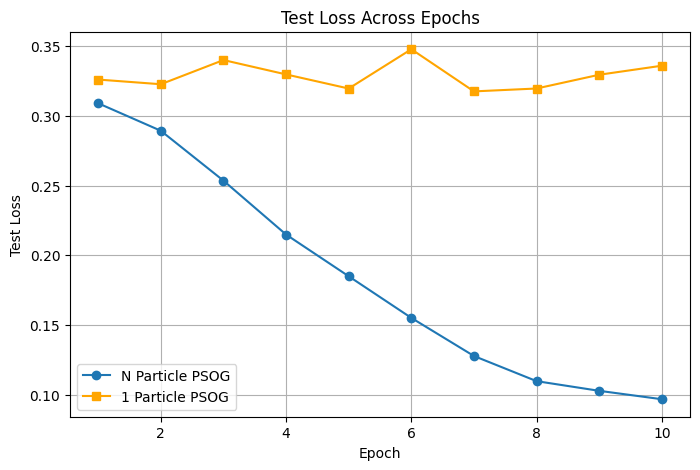

In [24]:
import matplotlib.pyplot as plt
import numpy as np

epochs = range(1, n_epochs+1)

# GD: mean across 3 runs
psoswarm_hybrid_plot = psoswarm_hybrid["test_losses"][0]
# PSO: single run
psog_plot = psog["test_losses"][0]

plt.figure(figsize=(8,5))
plt.plot(epochs, psoswarm_hybrid_plot, marker='o', label="N Particle PSOG")
plt.plot(epochs, psog_plot, marker='s', label="1 Particle PSOG", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.title("Test Loss Across Epochs")
plt.legend()
plt.grid(True)
plt.show()


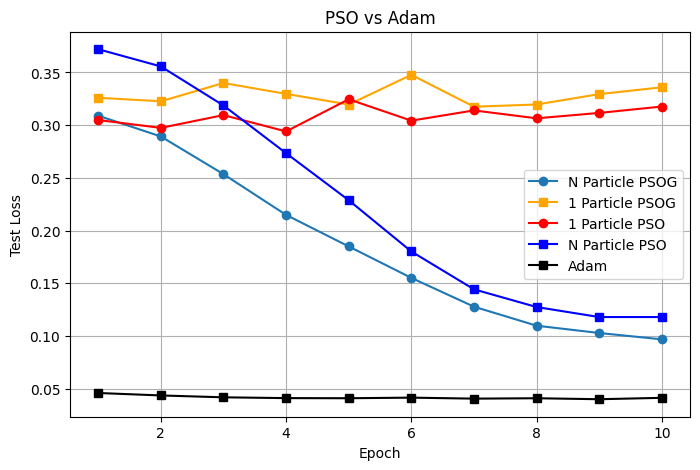

In [28]:
import matplotlib.pyplot as plt
import numpy as np

epochs = range(1, n_epochs+1)

gd_test_mean = np.mean(all_runs_test_losses, axis=0)


plt.figure(figsize=(8,5))
plt.plot(epochs, psoswarm_hybrid_plot, marker='o', label="N Particle PSOG")
plt.plot(epochs, psog_plot, marker='s', label="1 Particle PSOG", color="orange")
plt.plot(epochs, pso_plot, marker='o', label="1 Particle PSO",color="red")
plt.plot(epochs, psoswarm_plot, marker='s', label="N Particle PSO", color="blue")
plt.plot(epochs, gd_test_mean, marker='s', label="Adam", color="black")
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.title("PSO vs Adam")
plt.legend()
plt.grid(True)
plt.show()
